In [1]:
#Importing Packages
import numpy as np
from tinygp import kernels, GaussianProcess
import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import arviz as az
from src.model_fitting_functions import run_inference
from src.examples_functions import tinygp_model

import tinygp
import numpyro
import numpyro.distributions as dist

plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.4

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
jax.config.update("jax_enable_x64", True)

In [2]:
#Generating Underlying Process Data 
X = jnp.arange(0,120,0.1)
#Truth
GP = GaussianProcess(1 * kernels.ExpSquared(1),X,diag=1e-5,mean=1.0)
#Bias
GP2 = GaussianProcess(1 * kernels.ExpSquared(5),X,diag=1e-5,mean=-1.0)
#Climate
GP3 = GaussianProcess(1 * kernels.ExpSquared(1)+kernels.ExpSquared(5),X,diag=2e-5,mean=0.0)

mask = np.ones(len(X),dtype='bool')
mask[slice(int(len(X)/3),int(len(X)*2/3))]=False

In [3]:
Y = GP.sample(rng_key)
Y2 = GP2.sample(rng_key)
Y3 = GP3.sample(rng_key)

cx = X[::10]  

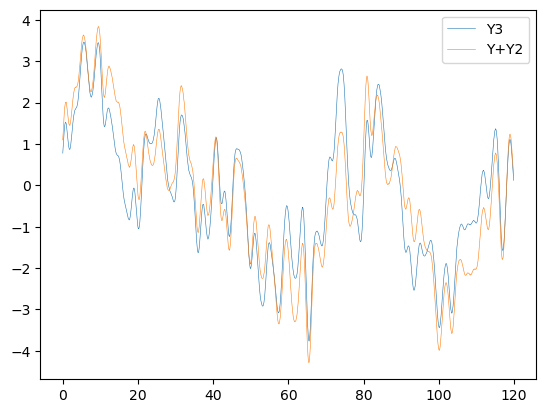

In [4]:
plt.plot(X,Y3,label='Y3')
plt.plot(X,Y+Y2,label='Y+Y2')
plt.legend()

In [5]:
class Noise(tinygp.kernels.Kernel):
    def __init__(self, noise):
        self.noise = noise

    def evaluate(self, X1, X2):
        return(jnp.where(X1==X2,self.noise,0))

def tinygp_2process_model(cx,cdata=None):
    """
   Example model where the climate data is generated from 2 GPs, one of which also generates the observations and one of which generates bias in the climate model.
    Args:
        cx (jax device array): array of coordinates for climate model, shape [#gridcells,dimcoords]
        ox (jax device array): array of coordinates for observations, shape [#sites,dimcoords]
        cdata (jax device array): array of data values for climate model, shape [#gridcells,]
        odata (jax device array): array of data values for climateervations, shape [#sites,]
    """

    #GP that generates the truth (& so the climateervations directly)
    kern_var = numpyro.sample("kern_var", dist.Gamma(3.0,0.5))
    lengthscale = numpyro.sample("lengthscale", dist.Gamma(3.0,0.5))
    kernel = kern_var * kernels.ExpSquared(lengthscale) + Noise(1e-5)
    mean = numpyro.sample("mean", dist.Normal(0.0, 2.0))

    bkern_var = numpyro.sample("bkern_var", dist.Gamma(3.0,0.5))
    blengthscale = numpyro.sample("blengthscale", dist.Gamma(3.0,0.5))
    bkernel = bkern_var * kernels.ExpSquared(blengthscale) + Noise(1e-5)
    bmean = numpyro.sample("bmean", dist.Normal(0.0, 2.0))

    ckernel = kernel+bkernel
    cgp = GaussianProcess(ckernel, cx, mean=mean+bmean)
    numpyro.sample("climate_temperature", cgp.numpyro_dist(),obs=cdata)

In [6]:
cdata = (Y+Y2)[::10] 
mcmc_2process = run_inference(tinygp_2process_model, rng_key_, 1000, 2000, cx,cdata=cdata)
idata_test = az.from_numpyro(mcmc_2process)
az.summary(idata_test,hdi_prob=0.95)
# az.plot_trace(idata_test)

sample: 100%|██████████| 3000/3000 [01:28<00:00, 33.86it/s, 7 steps of size 3.04e-01. acc. prob=0.94] 



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
     bkern_var      4.27      2.01      3.85      1.29      7.04   1273.99      1.00
  blengthscale     10.53      2.03     10.36      7.44     14.12   1349.11      1.00
         bmean      0.01      1.51      0.01     -2.43      2.43    982.24      1.00
      kern_var      0.81      0.16      0.79      0.57      1.05   1370.03      1.00
   lengthscale      0.93      0.05      0.94      0.85      1.01   1139.49      1.00
          mean     -0.08      1.51     -0.10     -2.57      2.28   1017.18      1.00

Number of divergences: 0
Time Taken: 91.84096184372902


Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bkern_var,4.275,2.008,1.168,8.328,0.056,0.040,1242.0,1149.0,NaN
blengthscale,10.532,2.032,7.191,15.073,0.056,0.039,1312.0,925.0,NaN
bmean,0.009,1.508,-2.745,2.920,0.048,0.035,986.0,1353.0,NaN
kern_var,0.806,0.156,0.514,1.101,0.004,0.003,1433.0,1439.0,NaN
lengthscale,0.934,0.050,0.834,1.032,0.001,0.001,1167.0,841.0,NaN
mean,-0.083,1.512,-2.935,2.677,0.047,0.034,1029.0,1400.0,NaN


In [7]:
cdata_y3 = Y3[::10]
mcmc_2process_y3 = run_inference(tinygp_2process_model, rng_key_, 1000, 2000, cx,cdata=cdata_y3)
idata_test_y3 = az.from_numpyro(mcmc_2process_y3)
az.summary(idata_test_y3,hdi_prob=0.95)

sample: 100%|██████████| 3000/3000 [01:53<00:00, 26.38it/s, 15 steps of size 2.41e-01. acc. prob=0.93]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
     bkern_var      2.90      1.42      2.58      0.78      4.88    906.60      1.00
  blengthscale      7.30      2.66      6.82      3.54     11.39    895.05      1.00
         bmean     -0.14      1.45     -0.12     -2.45      2.29   1126.45      1.00
      kern_var      1.04      0.22      1.02      0.68      1.39   1115.53      1.00
   lengthscale      0.98      0.05      0.99      0.90      1.06    946.64      1.00
          mean      0.04      1.45      0.03     -2.03      2.71   1084.70      1.00

Number of divergences: 0
Time Taken: 114.4254353120923


Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bkern_var,2.896,1.423,0.826,5.937,0.047,0.034,951.0,1091.0,NaN
blengthscale,7.304,2.665,3.248,12.691,0.089,0.064,968.0,1274.0,NaN
bmean,-0.143,1.447,-3.069,2.607,0.043,0.035,1130.0,1195.0,NaN
kern_var,1.040,0.224,0.639,1.485,0.007,0.005,1051.0,925.0,NaN
lengthscale,0.983,0.051,0.874,1.073,0.002,0.001,1075.0,905.0,NaN
mean,0.037,1.448,-2.980,2.670,0.044,0.034,1088.0,1225.0,NaN


In [8]:
#Test on just bias data:
bx = X[::10] 
bdata = Y2[::10] 

mcmc_1process = run_inference(tinygp_model, rng_key_, 1000, 2000, bx,data=bdata)
idata_test = az.from_numpyro(mcmc_1process)
az.summary(idata_test,hdi_prob=0.95)

sample: 100%|██████████| 3000/3000 [00:45<00:00, 65.85it/s, 7 steps of size 5.07e-01. acc. prob=0.93]  



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     kern_var      1.89      0.65      1.76      0.93      2.79   1016.21      1.00
  lengthscale      5.25      0.14      5.26      5.02      5.49   1115.57      1.00
         mean     -1.14      0.41     -1.13     -1.83     -0.49   1146.25      1.00

Number of divergences: 0
Time Taken: 46.37813803181052


Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kern_var,1.886,0.652,0.905,3.230,0.020,0.015,1057.0,1080.0,NaN
lengthscale,5.253,0.143,4.983,5.539,0.004,0.003,1118.0,1169.0,NaN
mean,-1.141,0.414,-1.919,-0.280,0.012,0.009,1153.0,712.0,NaN
